# Building a Random Forest Classifier to Predict League of Legends Wins

League of Legends (LoL) is an internationally popular and highly competitive online multiplayer team game. Two teams of five players play against each other on a symmetrical map: one side is team 1 side, the other side is team 2 side. In order to win teams must destroy towers and inhibitor(s) to reach the other side of the map and destroy the enemy team's nexus. Each nexus is protected by 2 towers, these towers are invincible until AT LEAST 1 inhibitor has been destroyed. Inhibitors remain invincible until the 3 towers in the lane leading up to the inhibitor have been sequentially destroyed. Thus, in order to secure a win, a team must destroy AT LEAST 5 towers (3 lane towers leading up to the inhibitor, as well as the 2 towers guarding the nexus) and 1 inhibitor.

Although it is necessary to destroy the nexus (which means destroying at least 5 towers and an inhibitor) in order to secure a win, there are many factors that contribute to how quickly players are able to destroy towers and inhibitor(s). Players often argue about which factors (besides towers and inhibitors) to focus on in a game (factors such as player, dragon, baron, rift herald kills). Therefore, in this project I will attempt to answer what factors are most important for winning a LoL game.

I will be using data collected from over 50,000 randomly selected ranked (rank unspecified) games of LoL from the EUW (Europe West) server. Obtained from https://www.kaggle.com/datasets/datasnaek/league-of-legends?resource=download

## Objectives:
1. Determine which factors are most important to securing a win.
2. Build a Random Forest classifier to predict game wins.
3. Based on exploratory data analysis and classifier, establish a safe and consistent winning strategy.

In [480]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report

In [469]:
data = pd.read_csv('games.csv')

print(data.columns)

print(data.seasonId.value_counts())

df = data[['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
           'firstDragon', 'firstRiftHerald', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 
           't1_dragonKills', 't1_riftHeraldKills', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 
           't2_dragonKills', 't2_riftHeraldKills']]
df.rename(columns={'winner': 'winning_team'}, inplace=True)

print(df.head())
print(df.info())
print(df.winning_team.value_counts(normalize=True))

Index(['gameId', 'creationTime', 'gameDuration', 'seasonId', 'winner',
       'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1',
       't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2',
       't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1',
       't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills',
       't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3',
       't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id',
       't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1',
       't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHer

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


This dataset contains NO missing values. Importantly it also has a nearly 50/50 ratio of wins from each team, this will be important in training the Random Forest model so that the model isn't biased.

Another important point: all the games in the data set are from Season 9. Different seasons have different game dynamics since Riot, creator of LoL, frequently adds patches/updates to the game. Therefore, data from one season may not be generalizable to another season.

For this project I'm only using the columns selected above in "df". Champion bans and picks, summoner spells, etc. would be interesting to explore in terms of how they contribute to wins, but would require a different approach for building a machine learning model (champions etc. could be number coded, or NLP could be used and a Naive Bayes Classifier built), which is why I'm excluding these columns from my analysis.

There is no need to scale (ie. normalize, standardize, etc.) the data because I will be using a Random Forest classifier, which relies on data partitioning rather than data point distances (such as algorithms that utilize Euclidian distance).

# Exploratory Data Visualization and Analysis

<Figure size 7200x7200 with 0 Axes>

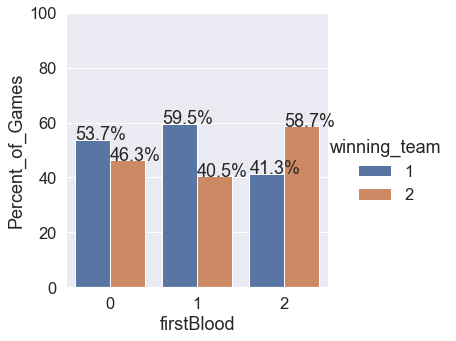

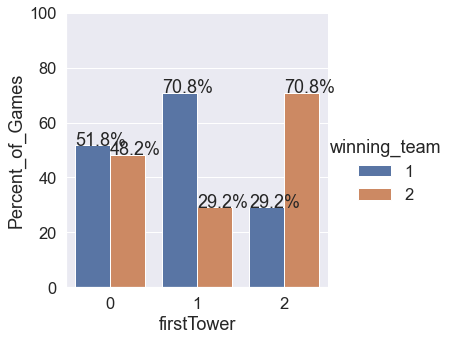

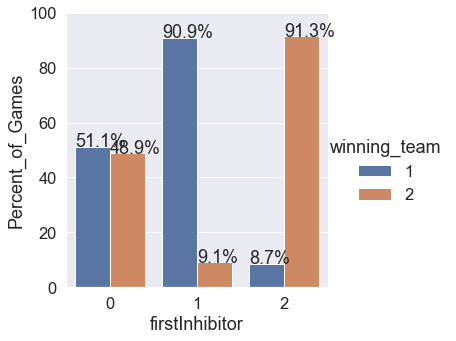

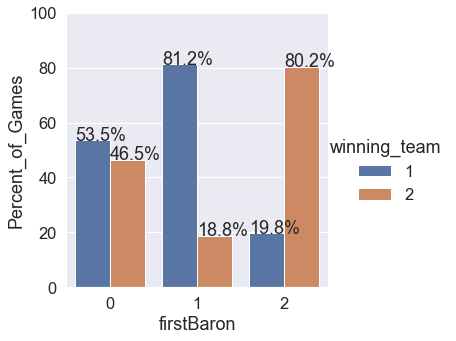

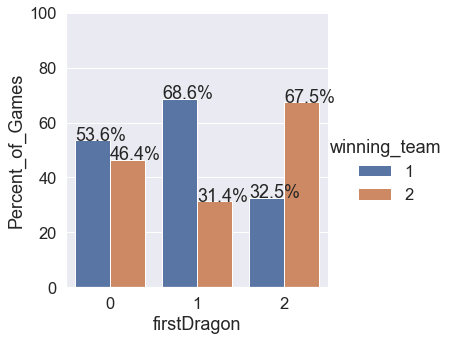

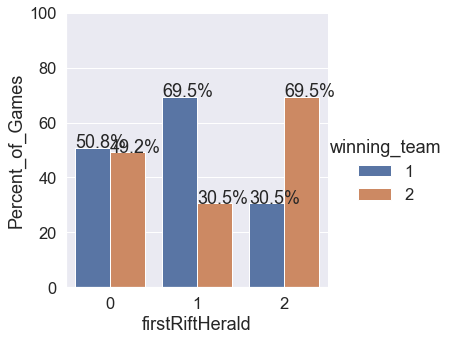

In [470]:
def first_claims(df, columns_list):
    fig = plt.figure(figsize=(100, 100))
    for i in range(len(columns_list)):
        col = columns_list[i]
        new_df = df.groupby(col)['winning_team'].value_counts(normalize=True)
        new_df = new_df.mul(100).rename('Percent_of_Games').reset_index()

        g = sns.catplot(x=col, y='Percent_of_Games', hue='winning_team', kind='bar', data=new_df)
        g.ax.set_ylim(0,100)

        for p in g.ax.patches:
            txt = str(p.get_height().round(1)) + '%'
            txt_x = p.get_x()
            txt_y = p.get_height()
            g.ax.text(txt_x,txt_y,txt)

        
        plt.show()
        
first_claims(df, ['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
           'firstDragon', 'firstRiftHerald'])

Based on the above bar charts it appears that securing first kills is important for winning the game. Securing the first inhibitor kill appears especially important to winning, while securing first blood kill appears least important out of all the first kill features examined here.

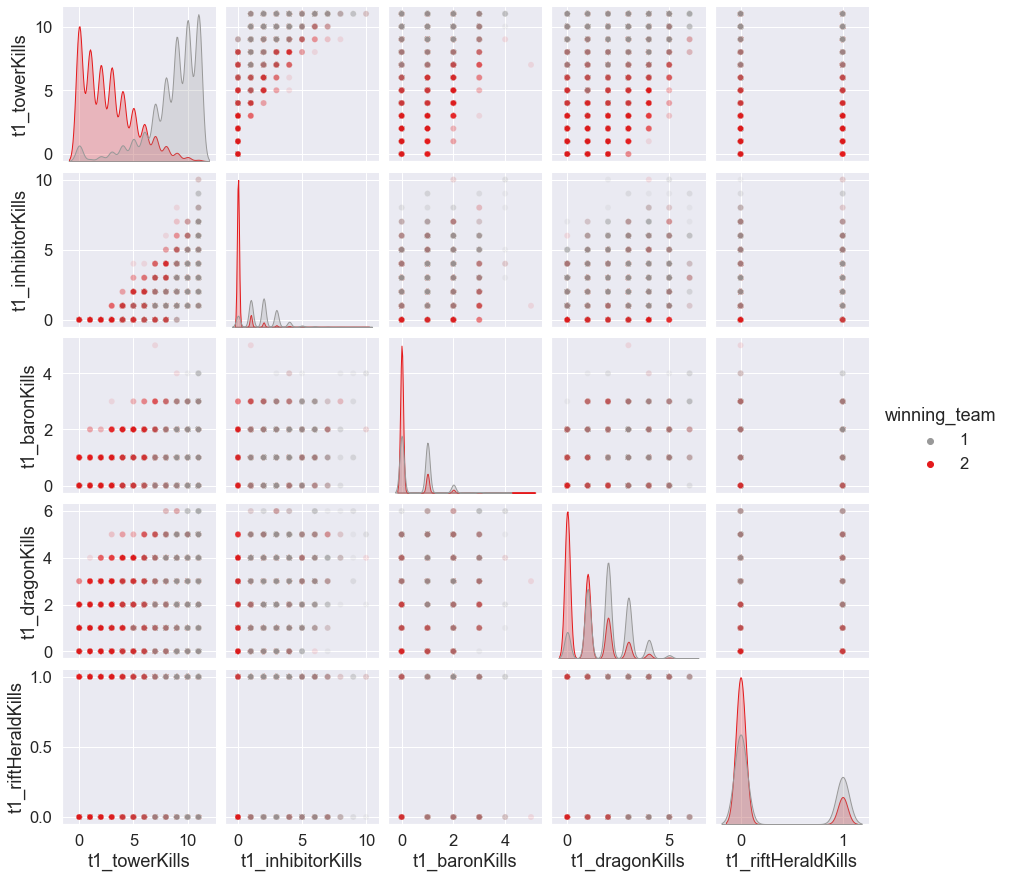

In [472]:
kill_counts_team1 = df[['winning_team', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 
           't1_dragonKills', 't1_riftHeraldKills']]

sns.pairplot(data=kill_counts_team1, hue='winning_team', plot_kws={'alpha': 0.1}, palette='Set1_r')
plt.show()

The above plots examine team 1 kills against winning/losing. Gray represents WINS for team 1, whereas red represents LOSSES for team 1 (red represents team 2 wins, which are LOSSES for team 1).

It appears tower kills are most important for securing a win. This makes sense, because in order to win (unless the enemy team surrenders) a minimum of 5 towers and 1 inhibitor must be destroyed to reach the nexus.

Monster kills (dragon, baron, and rift herald) also appear to be somewhat important to winning.

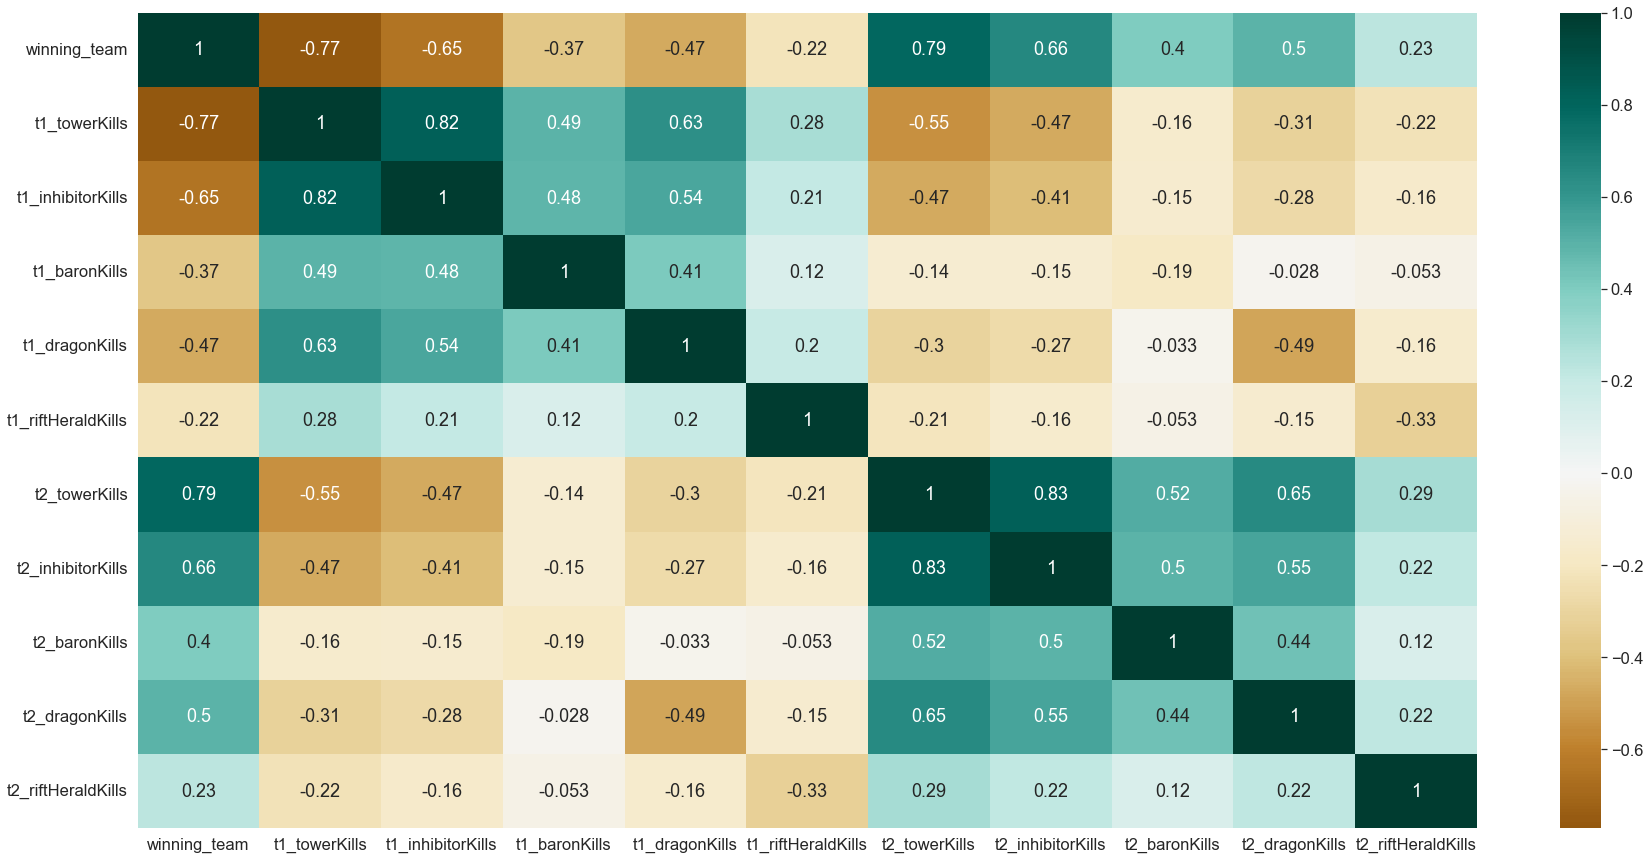

In [473]:
kill_counts = df[['winning_team', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 
           't1_dragonKills', 't1_riftHeraldKills', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 
           't2_dragonKills', 't2_riftHeraldKills']]

fig, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(kill_counts.corr(), center=0, cmap='BrBG', annot=True)
plt.show()

The above heatmap shows Pearson correlation coefficients for each pairwise comparison of features. I will be focusing on comparisons with "winning_team" (top-most row), because I'm interested in identifying which factors are likely to be most important for predicting a win.

Corroborating what was observed in the team 1 pairplot, it appears that tower and inhibitor kills are most strongly correlated with a win, followed by monster kills. It makes sense that monster kills are correlated with winning, because monster kills confer various buffs which help the team kill enemy players as well as towers and inhibitors. Indeed, this can be seen by looking at the towerKills to monster kills comparisons. For instance, team 1 tower kills is strongly correlated with team 1 monster kills.

# Building the Classifier

In [474]:
features = df[['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
           'firstDragon', 'firstRiftHerald', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 
           't1_dragonKills', 't1_riftHeraldKills', 't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 
           't2_dragonKills', 't2_riftHeraldKills']]

target = df[['winning_team']]

X_train, X_test, y_train, y_test = train_test_split(features, target)

First I will create a training set including ALL of the dataset features.
I will use the Random Forest classifier, as it is able to use both quantitative and categorical features, and doesn't require scaling quantitative data.

In [475]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
print('Accuracy = ' + str(random_forest.score(X_test, y_test)))

y_pred_test = random_forest.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

/var/folders/wp/8ln6f3ln26l_mhwbv0nvg5440000gn/T/ipykernel_1086/4261141345.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


Accuracy = 0.9704808513943913
[[6369  162]
 [ 218 6124]]
              precision    recall  f1-score   support

           1       0.97      0.98      0.97      6531
           2       0.97      0.97      0.97      6342

    accuracy                           0.97     12873
   macro avg       0.97      0.97      0.97     12873
weighted avg       0.97      0.97      0.97     12873



The random forest classifier's accuracy and f1-score are quite good. The confusion matrix (under the accuracy score) shows that the classifier was slightly biased in classifying team 2 wins as team 1 wins, but it doesn't appear to be to an appreciable extent.

Below I will explore which features were most important to the classifier based on Random Forest's built-in feature_importances_ attribute. I will see if I can improve my classifier by eliminating some features from the training set.

### Improving Model Performance: Feature Selection

                    importance
feature                       
t2_towerKills            0.258
t1_towerKills            0.240
t2_inhibitorKills        0.145
t1_inhibitorKills        0.142
firstInhibitor           0.082
t1_dragonKills           0.030
t2_dragonKills           0.028
t2_baronKills            0.017
firstTower               0.016
t1_baronKills            0.015
firstBlood               0.006
firstBaron               0.006
firstDragon              0.006
firstRiftHerald          0.004
t1_riftHeraldKills       0.002
t2_riftHeraldKills       0.002


<AxesSubplot:xlabel='feature'>

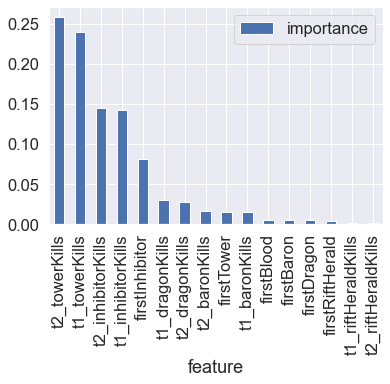

In [476]:
importances = pd.DataFrame({'feature': X_train.columns, 'importance': np.round(random_forest.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
print(importances)
importances.plot.bar()

It appears that tower and inhibitor kills, as well as first inhibitor kill, are most important to the model. Below I will only include these top 5 features in the training data and then assess how the model performs.

In [477]:
features = df[['firstInhibitor', 't1_towerKills', 't1_inhibitorKills', 't2_towerKills', 't2_inhibitorKills']]

target = df[['winning_team']]

X_train, X_test, y_train, y_test = train_test_split(features, target)

In [483]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
print('Accuracy = ' + str(random_forest.score(X_test, y_test)))

y_pred_test = random_forest.predict(X_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

/var/folders/wp/8ln6f3ln26l_mhwbv0nvg5440000gn/T/ipykernel_1086/4261141345.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


Accuracy = 0.967373572593801
[[6359  130]
 [ 290 6094]]
              precision    recall  f1-score   support

           1       0.96      0.98      0.97      6489
           2       0.98      0.95      0.97      6384

    accuracy                           0.97     12873
   macro avg       0.97      0.97      0.97     12873
weighted avg       0.97      0.97      0.97     12873



In [479]:
y_test.value_counts(normalize=True)

winning_team
1               0.504078
2               0.495922
dtype: float64

Even with excluding all features but tower kills, inhibitor kills, and first inhibitor kill the model performs similarly to when all features were included. It can be good to reduce the number of features in the training set to avoid overfitting models.

It appears the model is still disproportionately mis-classifying team 2 wins as team 1 wins. This could be explained by the fact that there is slightly less training data for team 2 wins compared to team 1 wins. Therefore, based on random guessing alone, the model will be more likely to correctly classify team 1 wins.

# Conclusions:
1. A greater number of tower, inhibitor, and monster kills is correlated with winning (less kills correlated with losing).
2. Number of tower and inhibitor kills are MOST strongly correlated with winning, compared to monster kills which are LESS important to winning.
3. Securing the first inhibitor is strongly associated with winning, but it appears that securing other first kills (such as baron, dragon, tower, etc.) is also important to winning.
4. Random Forest classifier was successfully built and was able to predict with around 97% accuracy and 0.97 F1-score the outcome of a game (team 1 or team 2 win). Tower and inhibitor kills, as well as first inhibitor kill were determined to be the most important features for training the classifier.
5. It's clear that towers and inhibitors are critical to winning. Monster kills are also likely important to winning, as they influence tower and inhibitor kills. It appears that dragon is the most important out of all monsters in contributing to winning, while rift herald seems to be the least important.

### Strategy:
Based on the above data and conclusions, focusing on tower kills and securing the first inhibitor before the enemy, as well as getting dragon kills, is likely a safe and consistent strategy for winning.

### Limitations/Generalizability:
First, all of the data is from Season 9. As mentioned earlier in this analysis, game dynamics change from season to season. Therefore, findings in this analysis of Season 9 games may not be generalizable to games in future seasons.

Second, the data set does not specify what rank the games are from, or if they are randomly selected from all ranked games. If games are only selected from a certain rank (ie Diamond or Bronze) this would likely impact the generalizability of the above conclusions, as players of different ranks may play differently (for instance, Diamond players may implement different strategies compared to Bronze players). 

Along this same vein, it's also important to note that this data is collected from the EUW server. Thus, it's also possible that EUW players play differently compared to, for instance, NA (North America) players. Finally, this data doesn't consider many other game components, such as team minion kills, gold, etc., that are also likely important to winning.

### Future Directions:
It would be interesting to determine important time "check points" or goals throughtout the game that are most likely to lead to a win. For example, is there a best time(s) to secure dragon(s)? Is securing first inhibitor earlier in the game more likely to lead to a win vs. securing it later in game?